In [1]:
#环境导入
import shutil
from os.path import join, isdir, isfile
from os import makedirs
import os
import json
import cv2
import glob
import ipywidgets as widgets

import torch
import torch.nn as nn
from torch.utils.data import dataloader
from torchvision import transforms
import numpy as np
import time
import numpy.random as npr
from torch.utils.data import Dataset, DataLoader


from dataset import OTB
from util import complex_mulconj,complex_mul
from util import gaussian_shaped_labels, AverageMeter, rect1_2_cxy_wh, cxy_wh_2_rect
from DCFNetTracker import DCFNetTracker

#创建模型检查点存储地址
#检查点都会存储在save文件夹下
save_path = join("save")
if not isdir(save_path):
    makedirs(save_path)

In [2]:
#########定义config类##########
class TrainConfig(object):
    crop_sz = 125
    output_sz = 125

    lambda0 = 1e-4
    padding = 2.0
    output_sigma_factor = 0.1

    output_sigma = crop_sz / (1 + padding) * output_sigma_factor
    y = gaussian_shaped_labels(output_sigma, [output_sz, output_sz])
    yf = torch.rfft(torch.Tensor(y).view(1, 1, output_sz, output_sz).cuda(), signal_ndim=2)
    input_sz = 125
    padding = 2.0
    
    range = 20 # 抽取的两帧之间的最大距离
    
    start_epoch = 0 # 起始epoch
    epochs = 5 # 训练进行的总epoch数
    workers = 8 # DataLoader参数
    batch_size = 64 # DataLoader参数 每组包含的数据个数
    
    lr = 0.01 # 优化器参数 
    momentum = 0.9 # 优化器参数 
    weight_decay=5e-5 # 优化器参数 



In [3]:
######################定义DCFNet网络################
class DCFNet(nn.Module):
    def __init__(self, config=None):
        super(DCFNet, self).__init__()
        #DCFNet feature
        self.feature = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), # in_channel, out_channel ,kennel_size， padding
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=1),
        )
        self.config = config
    
    def forward(self, x):
        x = self.feature(x) * self.config.cos_window
        xf = torch.rfft(x, signal_ndim=2)
        kxzf = torch.sum(complex_mulconj(xf, self.model_zf), dim=1, keepdim=True)
        response = torch.irfft(complex_mul(kxzf, self.model_alphaf), signal_ndim=2)
        return response

    def update(self, z, lr=1.):
        #z的shape为[1,3,125,125]
        #[1,3,125,125] ->[1,32,125,125]
        z = self.feature(z) * self.config.cos_window
        #[1,3,125,125] ->[1,32,125,63,2] 傅里叶变换
        zf = torch.rfft(z, signal_ndim=2)

        #kzzf = [1, 1, 125, 63, 1] 讲实部虚部和通道数都sum起来
        kzzf = torch.sum(torch.sum(zf ** 2, dim=4, keepdim=True), dim=1, keepdim=True)
        # alphaf = [1, 1, 125, 63, 2]
        alphaf = self.config.yf / (kzzf + self.config.lambda0)
        if lr > 0.99:
            self.model_alphaf = alphaf
            self.model_zf = zf
        else:
            self.model_alphaf = (1 - lr) * self.model_alphaf.data + lr * alphaf.data
            self.model_zf = (1 - lr) * self.model_zf.data + lr * zf.data
            
        # 用于训练
    def dotrain(self, z, x):
        z = self.feature(z)
        x = self.feature(x)
        zf = torch.rfft(z, signal_ndim=2)
        xf = torch.rfft(x, signal_ndim=2)

        kzzf = torch.sum(torch.sum(zf ** 2, dim=4, keepdim=True), dim=1, keepdim=True)
        kxzf = torch.sum(complex_mulconj(xf, zf), dim=1, keepdim=True)
        alphaf = self.config.yf.to(device=z.device) / (kzzf + self.config.lambda0)  # very Ugly
        response = torch.irfft(complex_mul(kxzf, alphaf), signal_ndim=2)
        
        return response
        #读取参数
    def load_param(self, path='param.pth'):
        checkpoint = torch.load(path)
        if 'state_dict' in checkpoint.keys():  # from training result
            state_dict = checkpoint['state_dict']
            if 'module' in list(state_dict.keys())[0]:  # train with nn.DataParallel
                from collections import OrderedDict
                new_state_dict = OrderedDict()
                for k, v in state_dict.items():
                    name = k[7:]  # remove `module.`
                    new_state_dict[name] = v
                self.load_state_dict(new_state_dict)
            else:
                self.load_state_dict(state_dict)
        else:
            self.feature.load_state_dict(checkpoint)





In [4]:
############定义训练以及验证相关的方法###################


#调整学习率
def adjust_learning_rate(optimizer, epoch):
    lr = np.logspace(-2, -5, num=config.epochs)[epoch]
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#存储检查点
def save_checkpoint(state, is_best, epoch, filename=save_path):
    filename = join(filename, 'checkpoint_ep_'+str(epoch)+'.pth')
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, join(save_path, 'model_best.pth'))

#训练函数
def train(train_loader, model, criterion, optimizer, epoch, target):
    #用于计算平均值
    batch_time = AverageMeter()
    losses = AverageMeter()

    # 切换到训练模式
    model.train()

    end = time.time()

    for i, (template, search) in enumerate(train_loader):

        template = template.cuda(non_blocking=True)
        search = search.cuda(non_blocking=True)

        # compute output
        output = model.dotrain(template, search)


        # 计算loss
        loss = criterion(output, target)/template.size(0)
        losses.update(loss.item())

        # 进行梯度下降
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 计算运行时间
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 30 == 0:
            print('Train: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} \t'
                  'Loss {loss.val:.4f} (loss.avg:{loss.avg:.4f})\t'.format(
                   epoch, i, len(train_loader), batch_time=batch_time, loss=losses))

#验证函数
def validate(val_loader, model, criterion, target):
    batch_time = AverageMeter()
    losses = AverageMeter()

    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (template, search) in enumerate(val_loader):

            # 获取template和search
            template = template.cuda(non_blocking=True)
            search = search.cuda(non_blocking=True)

            # 得到输出
            output = model.dotrain(template, search)
            loss = criterion(output, target)/(config.batch_size * gpu_num)

            # 计算损失
            losses.update(loss.item())

            # 计算运行时间
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 30 == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} \t'
                      'Loss {loss.val:.4f} (loss.avg: {loss.avg:.4f})\t'.format(
                       i, len(val_loader), batch_time=batch_time, loss=losses))

        print(' * Loss {loss.val:.4f} ({loss.avg:.4f})'.format(loss=losses))

    return losses.avg


#计算两个boundingbox的中心点偏移，bbox均为ltwh模式
def compute_center_error(bbox1,bbox2):
    cen1 = np.array([bbox1[0]+bbox1[2]-1/2,bbox1[1]+bbox1[3]-1/2])
    cen2 = np.array([bbox2[0]+bbox2[2]-1/2,bbox2[1]+bbox2[3]-1/2])
    errors = np.sqrt(np.sum(np.power(cen1 - cen2, 2)))
    return errors

#计算两个boundingbox的iou bbox均为ltwh模式
def compute_iou(bbox1,bbox2):
    l1, t1, r1, d1 = bbox1[0], bbox1[1], bbox1[0]+bbox1[2], bbox1[1]+bbox1[3]
    l2, t2, r2, d2 = bbox2[0], bbox2[1], bbox2[0]+bbox2[2], bbox2[1]+bbox2[3]
    l = max(l1,l2)
    t = max(t1,t2)
    r = min(r1,r2)
    d = min(d1,d2)
    innerarea = (r - l)*(d - t)
    if (r - l) <= 0 or (d - t)<=0:
        return 0.0
    outarea1 = bbox1[2] * bbox1[3]
    outarea2 = bbox2[2] * bbox2[3]
    return innerarea/(outarea1+outarea2-innerarea)

#储存dict函数
def jsonsave(filename,file):
    with open(filename, 'w') as f_obj:
        json.dump(file, f_obj)

In [5]:
 ##################参数设置#####################   


#生成config
config = TrainConfig()
#设置best_loss
best_loss = 1e6

#建立模型
model = DCFNet(config=config)
model.cuda()

#计算gpu数量
gpu_num = torch.cuda.device_count()
if gpu_num > 1:
    model = torch.nn.DataParallel(model, list(range(gpu_num))).cuda()



In [6]:
##################定义损失函数及优化器###########
#loss函数
criterion = nn.MSELoss(reduction = 'sum').cuda()

#优化器
optimizer = torch.optim.SGD(model.parameters(), config.lr,momentum=config.momentum,weight_decay=config.weight_decay)


In [7]:
#######开始训练##########

if __name__ == "__main__":

    #创建训练和验证数据集
    train_dataset = OTB(root_path="", train=True, range=config.range)
    val_dataset = OTB(root_path="", train=False, range=config.range)

    train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=config.batch_size*gpu_num,num_workers=config.workers,pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=config.batch_size*gpu_num, num_workers=config.workers,pin_memory=True)


    target = torch.Tensor(config.y).cuda().unsqueeze(0).unsqueeze(0).repeat(config.batch_size * gpu_num, 1, 1,
                                                                            1)  # for training
    #开始训练
    for epoch in range(config.start_epoch, config.epochs):
        #调整学习率
        adjust_learning_rate(optimizer, epoch)

        #训练
        train(train_loader, model, criterion, optimizer, epoch, target)

        #验证
        loss = validate(val_loader, model, criterion, target)

        # 储存当前的检查点以及记录最佳检查点
        is_best = loss < best_loss
        best_loss = min(best_loss, loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_loss': best_loss,
            'optimizer': optimizer.state_dict(),
        }, is_best,epoch)


Train: [0][0/1000]	Time 1.649 	Loss 49.8460 (loss.avg:49.8460)	
Train: [0][30/1000]	Time 0.074 	Loss 26.6179 (loss.avg:36.5831)	
Train: [0][60/1000]	Time 0.082 	Loss 32.2198 (loss.avg:33.5630)	
Train: [0][90/1000]	Time 0.077 	Loss 30.6660 (loss.avg:32.5831)	
Train: [0][120/1000]	Time 0.056 	Loss 28.9056 (loss.avg:31.8072)	
Train: [0][150/1000]	Time 0.099 	Loss 27.8561 (loss.avg:31.1412)	
Train: [0][180/1000]	Time 0.101 	Loss 25.2384 (loss.avg:30.5244)	
Train: [0][210/1000]	Time 0.072 	Loss 26.4344 (loss.avg:30.2639)	
Train: [0][240/1000]	Time 0.102 	Loss 22.6716 (loss.avg:29.9782)	
Train: [0][270/1000]	Time 0.087 	Loss 27.8819 (loss.avg:29.4544)	
Train: [0][300/1000]	Time 0.075 	Loss 26.5167 (loss.avg:29.0529)	
Train: [0][330/1000]	Time 0.063 	Loss 29.1000 (loss.avg:28.7270)	
Train: [0][360/1000]	Time 0.076 	Loss 24.4071 (loss.avg:28.4456)	
Train: [0][390/1000]	Time 0.084 	Loss 25.2812 (loss.avg:28.1950)	
Train: [0][420/1000]	Time 0.098 	Loss 19.6399 (loss.avg:27.8952)	
Train: [0][450/

In [8]:
###########定义TrackerConfig类####################
class TrackerConfig(object):
    crop_sz = 125

    lambda0 = 1e-4
    padding = 2
    output_sigma_factor = 0.1
    interp_factor = 0.01
    num_scale = 3
    scale_step = 1.0275
    scale_factor = scale_step ** (np.arange(num_scale) - num_scale / 2)
    min_scale_factor = 0.2
    max_scale_factor = 5
    scale_penalty = 0.9925
    scale_penalties = scale_penalty ** (np.abs((np.arange(num_scale) - num_scale / 2)))

    net_input_size = [crop_sz, crop_sz]
    net_average_image = np.array([104, 117, 123]).reshape(-1, 1, 1).astype(np.float32)
    output_sigma = crop_sz / (1 + padding) * output_sigma_factor
    y = gaussian_shaped_labels(output_sigma, net_input_size)
    yf = torch.rfft(torch.Tensor(y).view(1, 1, crop_sz, crop_sz).cuda(), signal_ndim=2)
    cos_window = torch.Tensor(np.outer(np.hanning(crop_sz), np.hanning(crop_sz))).cuda()

In [9]:
##########评估模型#############
#创建用于运行的DCFnet
trackerconfig = TrackerConfig()
net = DCFNet(config=trackerconfig)

#创建traker，导入检查点
traker = DCFNetTracker("save/model_best.pth",net,trackerconfig)

evaluate_save = dict()

# 用于存储每个视频的iou和center_error平均值
iou_means = []
center_error_means = []
dataset = "OTB100"
root_path = os.path.join('')
json_path = os.path.join(root_path, dataset + '.json')
annos = json.load(open(json_path, 'r'))
videos = sorted(annos.keys())

#选取六个视频用于评估
video =['blurCar1','basketball','skater2','sylvester','trellis','freeman3']
for name in video:
    # 视频名
    video_path_name = annos[name]['name']
    # 图像名
    imgs_name = annos[name]['image_files']
    # groundtruth
    imgs_gt = annos[name]['gt_rect']
    # 初始groudtruth
    init_rect = annos[name]['init_rect']

    image_files =[os.path.join(root_path, "OTB100", video_path_name, "img", i) for i in imgs_name]

    first_image = cv2.imread(image_files[0])
    
    imgbox = widgets.Image(format='jpg', height=first_image.shape[0], width=first_image.shape[1]) #创建图片展示套件
    display(imgbox)

    target_pos, target_sz = np.array([init_rect[0]+(init_rect[2]-1)//2,init_rect[1]+(init_rect[3]-1)//2]), np.array([init_rect[2],init_rect[3]])
    # 初始化跟踪器
    traker.init(first_image, target_pos, target_sz)

    # 存放每一帧的iou
    video_ious = []
    # 存放每一帧的中心坐标差
    video_center_errors = []

    for num, path_name in enumerate(image_files[1:]):
        im = cv2.imread(path_name)
        target_pos, target_sz = traker.track(im)
        boundingbox = cxy_wh_2_rect(target_pos, target_sz)
        gt = imgs_gt[num + 1]

        # OTB部分gt有误，跳过
        if imgs_gt[num + 1][2] == 0 or imgs_gt[num + 1][3] == 0:
            continue


        # 计算iou
        iou = compute_iou(boundingbox, gt)
        # 计算center_error
        center_error = compute_center_error(boundingbox, gt)


        res = [int(l) for l in boundingbox]
        # 跟踪框绘制
        cv2.rectangle(im, (res[0], res[1]), (res[0] + res[2], res[1] + res[3]), (0, 255, 255), 3)
        cv2.rectangle(im, (imgs_gt[num+1][0], imgs_gt[num+1][1]), (imgs_gt[num+1][0] + imgs_gt[num+1][2], imgs_gt[num+1][1] + imgs_gt[num+1][3]), (255, 0, 0), 3)
        cv2.putText(im, str(iou), (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

        # 显示跟踪结果
        imgbox.value = cv2.imencode('.jpg', im)[1].tobytes()
        cv2.waitKey(1)

        video_ious.append(iou)
        video_center_errors.append(center_error)
    # 计算avg
    iou_mean = np.mean(np.array(video_ious))
    center_error_mean = np.mean(np.array(video_center_errors))
    # 存储
    evaluate_save[name] = {
        "name": video_path_name,
        "video_ious": video_ious,
        "iou_mean": iou_mean,
        "video_center_errors": video_center_errors,
        "center_error_mean": center_error_mean
    }

    iou_means.append(iou_mean)
    center_error_means.append(center_error_mean)
    print(
        "video_name:{},  avg_iou:{}%, avg_center_error:{}".format(video_path_name, (iou_mean * 100), center_error_mean))

total_iou_mean = np.mean(np.array(iou_means))
total_center_error_mean = np.mean(np.array(center_error_means))
print("total_avg_iou:{}%, total_avg_center_error:{}".format((total_iou_mean * 100), total_center_error_mean))
#将结果存储起来
jsonsave("OTB_evaluate_save.json", evaluate_save)


Image(value=b'', format='jpg', height='480', width='640')

video_name:BlurCar1,  avg_iou:84.38464908065652%, avg_center_error:6.956587640913514


Image(value=b'', format='jpg', height='432', width='576')

video_name:Basketball,  avg_iou:29.702898182046532%, avg_center_error:19.053336042746768


Image(value=b'', format='jpg', height='262', width='320')

video_name:Skater2,  avg_iou:50.315876930347045%, avg_center_error:18.197589657618266


Image(value=b'', format='jpg', height='240', width='320')

video_name:Sylvester,  avg_iou:75.32418640568679%, avg_center_error:8.012673194194093


Image(value=b'', format='jpg', height='240', width='320')

video_name:Trellis,  avg_iou:78.97168150659468%, avg_center_error:6.719558078884307


Image(value=b'', format='jpg', height='240', width='360')

video_name:Freeman3,  avg_iou:75.62716758122454%, avg_center_error:2.45470510154182
total_avg_iou:65.72107661442601%, total_avg_center_error:10.232408285983128


In [10]:

import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
annos = json.load(open("OTB_evaluate_save.json", 'r'))

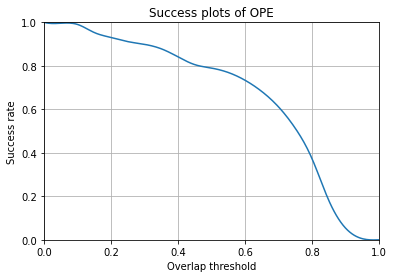

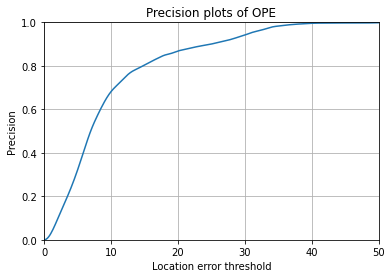

In [11]:
#################计算video_ious#########################
al = []
al = np.array(al)
for i in annos:
    al = np.append(al , annos[i]["video_ious"])
al = np.ndarray.flatten(al)
X = np.linspace(0, 1, 21, endpoint=True)
Y = np.zeros([21])
plt.axis([0,1,0,1])

for i in range(21):
        Y[i] = np.size(np.where(al>=X[i]))/np.size(al)

x_smooth = np.linspace(X.min(),X.max(),300) #300 represents number of points to make between T.min and T.max
# power_smooth = make_interp_spline(x_suc,L,xnew)
y_smooth = make_interp_spline(X,Y)(x_smooth)
# 加网格线
plt.grid()
# 标题 横纵坐标名
plt.title(u"Success plots of OPE")
plt.xlabel(u"Overlap threshold")
plt.ylabel(u"Success rate")

plt.plot(x_smooth,y_smooth)
plt.show()
##############################计算video_center_errors##########################
al = []
al = np.array(al)
for i in annos:
    al = np.append(al , annos[i]["video_center_errors"])
al = np.ndarray.flatten(al)
X = np.linspace(0, 50, 51, endpoint=True)
Y = np.zeros([51])
plt.axis([0,50,0,1])

for i in range(51):
        Y[i] = np.size(np.where(al<=X[i]))/np.size(al)

x_smooth = np.linspace(X.min(),X.max(),300) #300 represents number of points to make between T.min and T.max
# power_smooth = make_interp_spline(x_suc,L,xnew)
y_smooth = make_interp_spline(X,Y)(x_smooth)
# 加网格线
plt.grid()
# 标题 横纵坐标名
plt.title(u"Precision plots of OPE")
plt.xlabel(u"Location error threshold")
plt.ylabel(u"Precision")

plt.plot(x_smooth,y_smooth)
plt.show()